To make this notebook work, several things need to be done
-create the directories: "training_checkpoints", "cpimages"
-Download the img_align_celebA zip and unpack it into: "celebA"
-Change the paths used in this example, relative paths do NOT work because keras uses a different cwd

In [1]:
#---------------------------Only needed for FI-Code server
!export CUDA_VISIBLE_DEVICES="1" #having luxery problems that i have to choose which GPU i want to use
!TF_GPU_ALLOCATOR="cuda_malloc_async"
import os
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

__________________________________________________________________________________________________________________________
Import libraries

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import ops
import keras

2024-06-15 17:38:13.953958: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-15 17:38:13.999408: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#---------------------------Only needed for FI-Code server
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17120360628326242467
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 32065650688
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4351098489433770517
physical_device_desc: "device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:0b:00.0, compute capability: 7.0"
xla_global_id: 416903419
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 8346861568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7324049159339168958
physical_device_desc: "device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:13:00.0, compute capability: 7.0"
xla_global_id: 2144165316
]


2024-06-15 17:38:16.780057: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 17:38:16.780325: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 17:38:16.978483: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
tf.__version__

'2.16.1'

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow.keras
from tensorflow.keras import layers
import time
import cv2
from tqdm import tqdm
from IPython import display

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 512 #you might want to lower this number, together with the model this needs about 31GB in GPU memry

In [7]:
#(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data(path='/home/fin_eckhoff/Projects/GAN/mnist.npz') #loading from disk because jupyther and mnist takes long due to bugs # also using full path because keras somehow ignores realtive paths

In [8]:
dataset = tensorflow.keras.utils.image_dataset_from_directory(
    "/home/fin_eckhoff/Projects/GAN/celebA/img_align_celeba", label_mode=None, image_size=(64, 64), batch_size=BATCH_SIZE #change path to your path,  keras does not work for relative paths because it takes /keras/datasets as cwd
)

Found 202599 files.


2024-06-15 17:38:21.310438: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 17:38:21.310748: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-15 17:38:21.310927: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
dataset = dataset.map(lambda x: x / 255.0) #map to 0-1

Testing Dataset

In [10]:
t = next(iter(dataset))

In [11]:
np_img = t.numpy()

In [12]:
cv2.imwrite("test.png", np_img[0])

True

In [13]:
np.uint8(np_img[0]).max() #is still in range 0-1

1

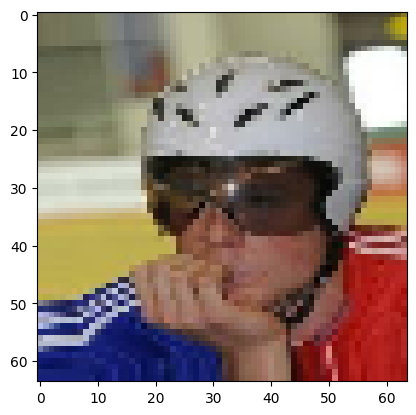

In [14]:
plt.imshow(np.uint8(np_img[0]*255)) # to get the image we need 0-255

In [15]:
# Batch and shuffle the data
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*128, use_bias=False, input_shape=(100,)))    #8x8 works better to get to 64
    model.add(layers.Reshape((8, 8, 128))) 
    #removed assertion because they bothered me while experimenting with the model, as long as the final output is 64x64x3 idc about the shape

    model.add(layers.Conv2DTranspose(128, (4, 4), strides=2, padding='same')) 

    model.add(layers.LeakyReLU()) 
    model.add(layers.BatchNormalization()) #moved to after activation (see https://github.com/keras-team/keras/issues/1802)


    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same'))

    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #added one more block
    model.add(layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.BatchNormalization())
    
    model.add(layers.Conv2D(3, (5, 5), strides=(1, 1), padding='same', activation='sigmoid'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [17]:
generator = make_generator_model()

/home/fin_eckhoff/miniforge-pypy3/envs/ML/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2024-06-15 17:38:22.891560: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


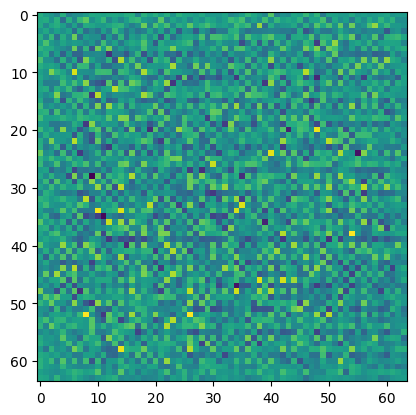

In [18]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [19]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', #change size from 28x28x1 to 64x64x3
                                     input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.1))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [20]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.03252791]], shape=(1, 1), dtype=float32)


/home/fin_eckhoff/miniforge-pypy3/envs/ML/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [22]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [23]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [24]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [26]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [27]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    BATCH_SIZE = images.shape[0]
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    generated_images = generator(noise)
    combined_images = ops.concatenate([generated_images, images], axis=0) #combine them along the batch axis to save time
    labels = ops.concatenate(
            [ops.ones((BATCH_SIZE, 1)), ops.zeros((BATCH_SIZE, 1))], axis=0 #also combine the labels along the same axis
        )
    
    labels += 0.05 * tf.random.uniform(tf.shape(labels)) #keras docu calls this "important trick" https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit
    
    with tf.GradientTape() as disc_tape: #pulled the two train cycles apart because im not sure if the disc weights get updated on the gen train, which we dont want, although this did work with the MNIST dataset
        predictions = discriminator(combined_images) 
        d_loss = cross_entropy(labels, predictions) 
    grads = disc_tape.gradient(d_loss, discriminator.trainable_weights)
    discriminator_optimizer.apply_gradients(
        zip(grads, discriminator.trainable_weights)
    )
    random_latent_vectors = keras.random.normal(shape=(BATCH_SIZE, noise_dim))
    misleading_labels = ops.zeros((BATCH_SIZE, 1))

    with tf.GradientTape() as gen_tape:
            predictions = discriminator(generator(random_latent_vectors))
            g_loss = cross_entropy(misleading_labels, predictions)
    grads = gen_tape.gradient(g_loss, generator.trainable_weights)
    generator_optimizer.apply_gradients(zip(grads, generator.trainable_weights))

   

In [28]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(2, 2))

  for i in range(predictions.shape[0]):
      plt.subplot(2, 2, i+1)
      np_img = predictions[i].numpy()
      plt.imshow(np.uint8(np_img * 255))
      #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5)
      plt.axis('off')

  plt.savefig('cpimages/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

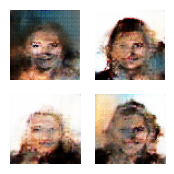

Time for epoch 122 is 525.6739299297333 sec


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 280/396 [06:10<02:33,  1.32s/it]

In [ ]:
train(dataset, EPOCHS)

In [ ]:
#LOADING IT, assuming generator, disc, and the optimizers have already been initilized

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint('/home/fin_eckhoff/Projects/GAN/training_checkpoints')).assert_consumed() #same with paths here